# **Data Visualization**

## Objectives

Answer business requirement 1:
 * The client is interested in conducting a study to visually differentiate a healthy cherry leaf from one with powdery mildew.

## Inputs

* inputs/cherry-leaves/test
* inputs/cherry-leaves/train
* inputs/cherry-leaves/validation

## Outputs

* Image shape embeddings file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between mildew-contained and uninfected leaf images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.



---

# Set Data Directory

---

### Import libraries

In [26]:
%pip install pandas==1.1.2
%pip install tensorflow==2.6.0
%pip install keras==2.6.0
%pip install matplotlib==3.3.1
%pip install seaborn==0.11.0
%pip install numpy==1.19.5


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


sns.set_style("whitegrid")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [27]:
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)
print("Matplotlib version:", plt.matplotlib.__version__)
print("Seaborn version:", sns.__version__)

# Testar TensorFlow
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


Pandas version: 1.1.2
NumPy version: 1.19.5
Matplotlib version: 3.3.1
Seaborn version: 0.11.0
TensorFlow version: 2.6.0


### Set working directories

In [28]:
cwd= os.getcwd()

In [29]:

os.chdir('/workspace/mildew-detector-cherryleaves')
print("You set a new current directory")

You set a new current directory


In [30]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector-cherryleaves'

### Setup the input directories

Set train, validation and test paths.

In [31]:
my_data_dir = '/workspace/mildew-detector-cherryleaves/inputs/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [32]:
version = '1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [33]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data Visualization

---

Image shape

Compute the average image size on the train set

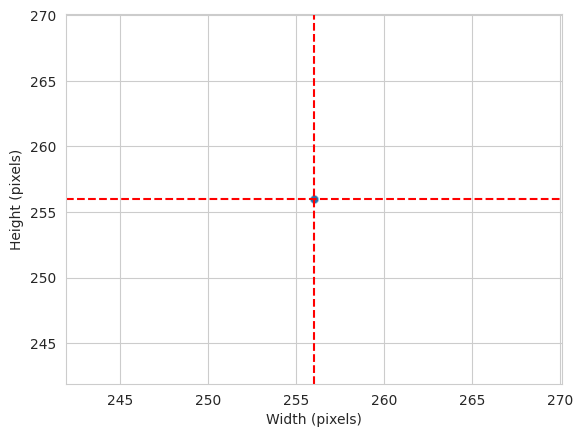

Width average: 256 
Height average: 256


In [34]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

The size of the images (256x256) for training the model is the average for all the images in the train set.

In [35]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

Save the image shape embeddings

In [36]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/1/image_shape.pkl']

---

### Average and variablityy of images per label

#### Function to load images in an array

In [37]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

Load image shape and labels in array

In [38]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


### Plot and save mean and variability of images per label

In [39]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False, file_path="./", watermark_text="My Model"):
    """
    This function visualizes the average image and variability (std dev) for each label.
    It includes a custom watermark and additional style options for personal touch.

    Parameters:
    - X: Numpy array of images
    - y: Labels corresponding to each image
    - figsize: Tuple for the figure size (default (12, 5))
    - save_image: Boolean to decide if the images should be saved
    - file_path: Path to save images if save_image is True
    - watermark_text: Text for the watermark on the images
    """
    for label_to_display in np.unique(y):
        sns.set_style("whitegrid")

        # Reshape y to ensure it aligns with X
        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        
        # Create a figure with custom styling
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        
        # Plot average image
        axes[0].set_title(f"Average image for label {label_to_display}", fontsize=14, color="blue")
        axes[0].imshow(avg_img, cmap='coolwarm')  # Changed to a custom colormap for uniqueness
        
        # Plot variability (standard deviation) image
        axes[1].set_title(f"Variability image for label {label_to_display}", fontsize=14, color="red")
        axes[1].imshow(std_img, cmap='coolwarm')  # Custom colormap
        
        # Add watermark (a personal touch)
        for ax in axes:
            ax.text(0.5, 0.05, watermark_text, color="gray", fontsize=12, ha="center", va="center", transform=ax.transAxes, alpha=0.5)

        # Adjust layout and save or show image
        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()

        print("\n")


==== Label healthy ====
Image Shape: (256, 256, 3)


==== Label powdery_mildew ====
Image Shape: (256, 256, 3)




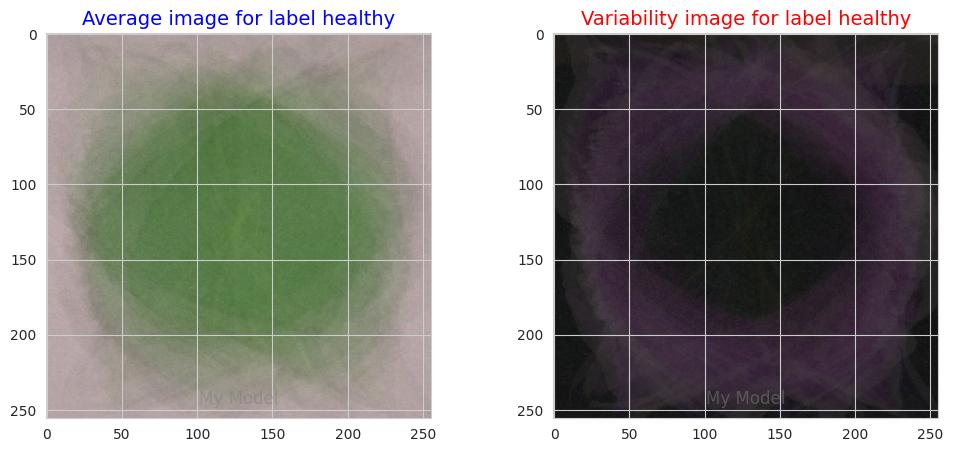

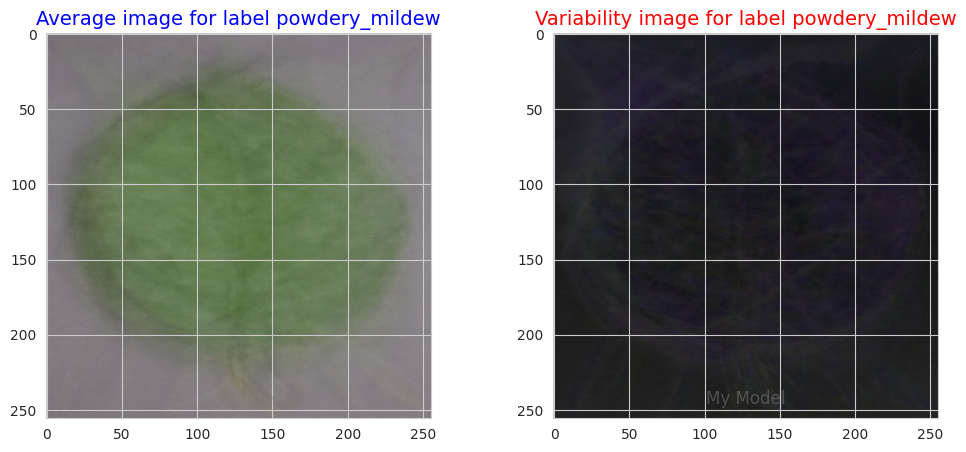

In [40]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

---

### Difference between average mildew-contained and average uninfected leaf images

---

In [41]:
def subset_image_label(X, y, label_to_display):
    """
    Filters the images and labels to keep only the ones that match the specified label.

    Parameters:
    - X: The images (as a numpy array)
    - y: The labels (as a numpy array)
    - label_to_display: The label to filter by

    Returns:
    - df: The images that belong to the given label
    """
    y = y.reshape(-1, 1, 1)  # Reshaping labels for comparison
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)  # Create a mask to find images with the target label
    df = X[boolean_mask]  # Filter the images based on the mask
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Compares the average images of two different labels by calculating their differences.
    Then, it plots these averages and the difference, and optionally saves the images.

    Parameters:
    - X: Array of images
    - y: Labels corresponding to each image
    - label_1: The first label to compare
    - label_2: The second label to compare
    - figsize: The size of the output image (default is (20, 5))
    - save_image: Whether to save the image to disk (default is False)

    Returns:
    - None (Displays and/or saves the images)
    """
    sns.set_style("white")  # Set the plot style to 'white'

    # Check if the specified labels exist in the dataset
    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2} is not in the dataset {np.unique(y)}")
        return

    # Get the average image for label 1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # Get the average image for label 2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # Calculate the difference between the two average images
    difference_mean = label1_avg - label2_avg

    # Create a plot with three subplots: label 1 average, label 2 average, and their difference
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    
    # Plot the average image for label 1
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    
    # Plot the average image for label 2
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    
    # Plot the difference between the two average images
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference between {label_1} and {label_2}')

    # Save or display the image based on the save_image flag
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


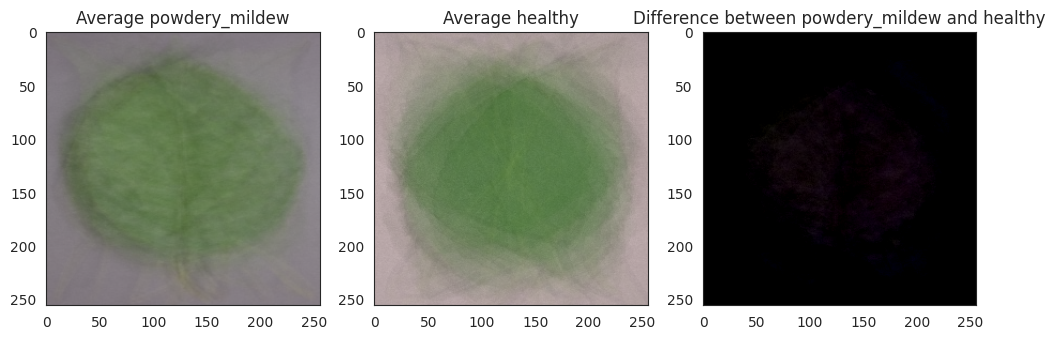

In [42]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(12, 10),
                                        save_image=True
                                        )

---

### Image Montage

In [43]:
import itertools
import random
sns.set_style("white")

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    """
    Creates an image montage from a specific label's images in the directory.

    Parameters:
    - dir_path: Path to the directory containing the images.
    - label_to_display: The label whose images will be shown.
    - nrows: Number of rows in the montage grid.
    - ncols: Number of columns in the montage grid.
    - figsize: Size of the output image montage (default is (15, 10)).

    Returns:
    - None (Displays the montage of images)
    """
    labels = os.listdir(dir_path)

    # Check if the label exists in the directory
    if label_to_display in labels:

        # Get the list of images in the selected label's directory
        images_list = os.listdir(dir_path + '/' + label_to_display)

        # Ensure that the number of spaces in the montage grid is not greater than the available images
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)  # Randomly sample images for the montage
        else:
            print(
                f"Reduce the number of rows or columns to fit the available images. \n"
                f"There are {len(images_list)} images for the selected label, but you requested a montage with {nrows * ncols} spaces."
            )
            return

        # Generate a list of all possible (row, column) positions for the grid
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))  # Create pairs of row/column indices

        # Create the figure for the montage and display the images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows * ncols):
            img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])  # Load the image
            img_shape = img.shape  # Get the image dimensions
            # Place the image in the corresponding spot in the montage
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")  # Display image dimensions in the title
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])  # Hide x-axis ticks
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])  # Hide y-axis ticks
        plt.tight_layout()  # Adjust the layout for better spacing
        plt.show()  # Show the final montage of images

    else:
        print("The label you selected doesn't exist in the directory.")
        print(f"Here are the available labels: {labels}")


Run the montage on all labels

healthy


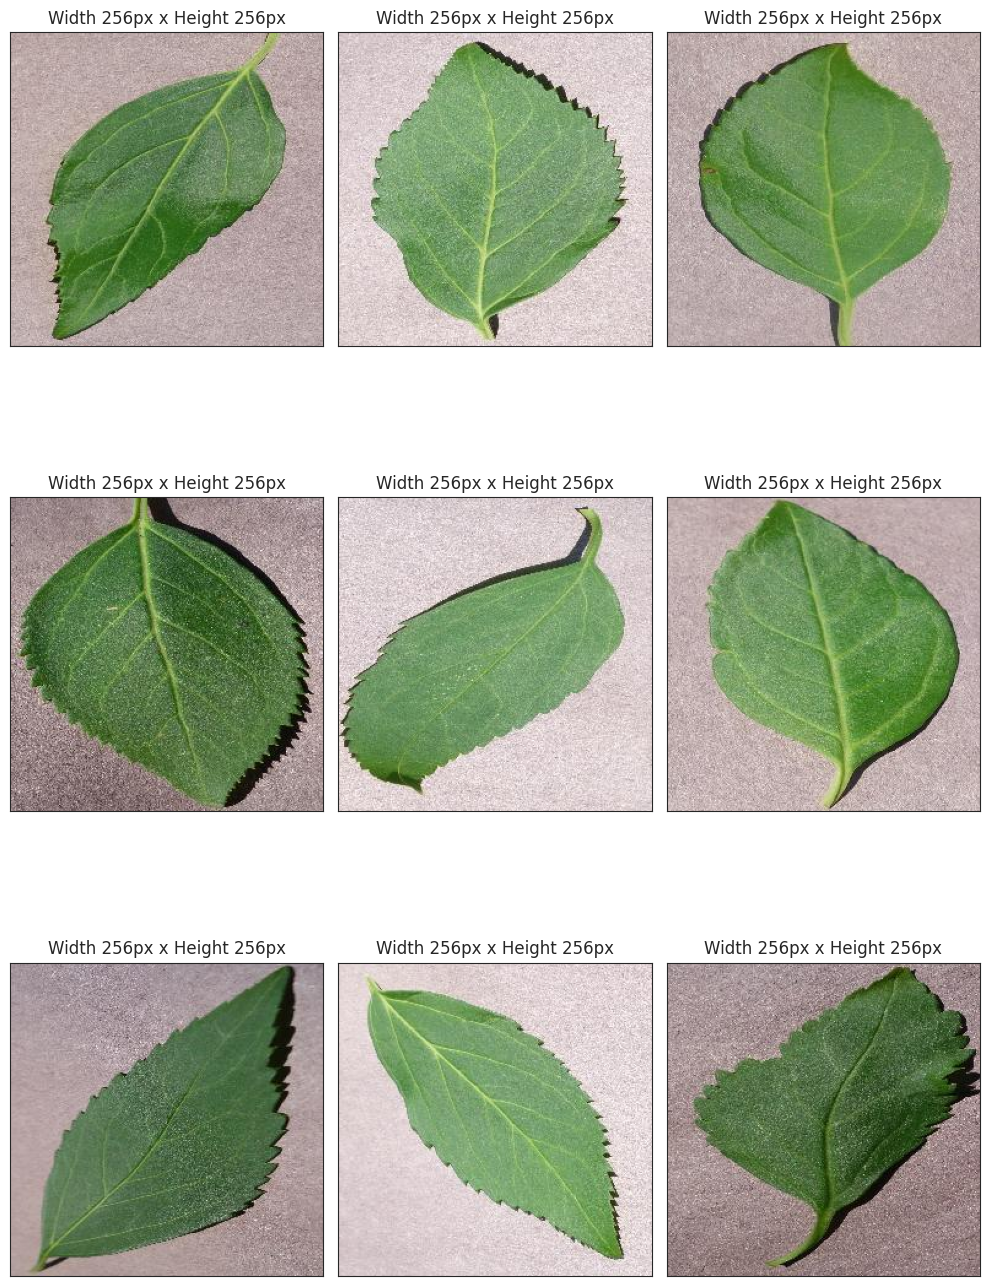



powdery_mildew


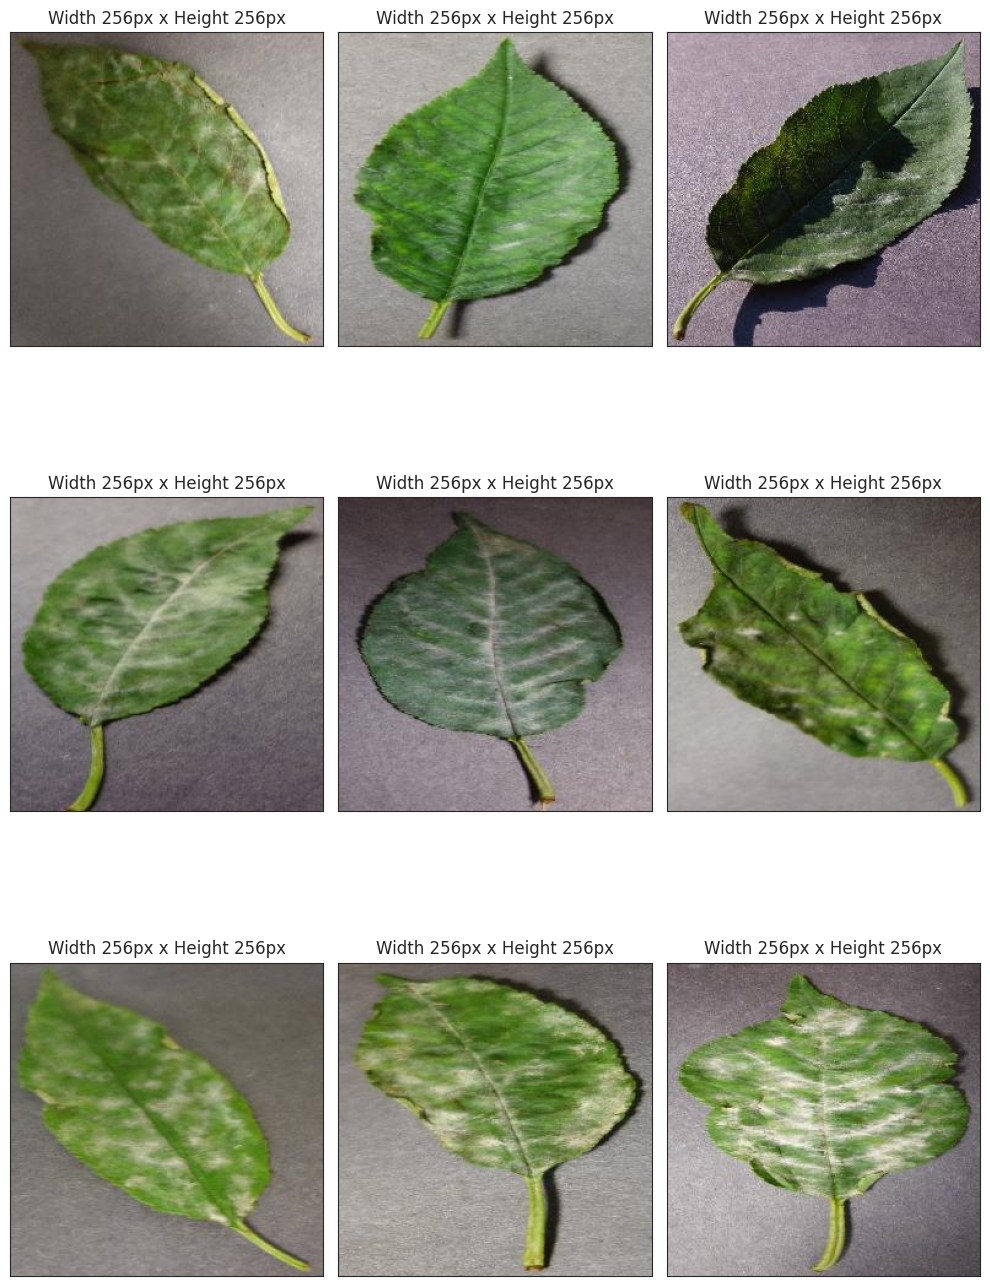

In [44]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  label_to_display=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")

---

# Conclusion

---

#### Data Visualization:
* By calculating the average image and plotting it, it became evident that all images in the dataset shared the same dimensions. Subsequently, the mean and variability of the images were visualized to better understand the dataset's characteristics.

#### Visualization Importance:
* To support and prepare the dataset for machine learning, the differences between healthy and non-healthy leaves were visualized. Additionally, a montage of images was created to provide a comprehensive overview of the dataset.

